# 01 - Data Ingestion & Processing

**Objective:** Load and merge demand + supply chain datasets to create a unified plant-level view for material allocation optimization.

---


## 1. Imports and Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("Setup complete!")

Setup complete!


## 2. Load Datasets

In [ ]:

# Load demand data (FreshRetailNet)
demand_df = pd.read_csv('../freshretailnet_full.csv')

# Load supply chain logistics data
supply_df = pd.read_csv('../data/dynamic_supply_chain_logistics_dataset.csv')

print(f"Demand data: {demand_df.shape[0]:,} rows, {demand_df.shape[1]} columns")
print(f"Supply data: {supply_df.shape[0]:,} rows, {supply_df.shape[1]} columns")


Demand data: 4,500,000 rows, 19 columns
Supply data: 32,065 rows, 26 columns


## 3. Explore Demand Data (FreshRetailNet)

In [5]:
print("=" * 60)
print("DEMAND DATA - FreshRetailNet")
print("=" * 60)
display(demand_df.head())

print("\nColumn types:")
print(demand_df.dtypes)

DEMAND DATA - FreshRetailNet


,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,sale_amount,hours_sale,stock_hour6_22_cnt,hours_stock_status,discount,holiday_flag,activity_flag,precpt,avg_temperature,avg_humidity,avg_wind_level
0,0,0,0,5,6,65,38,2024-03-28,0.1,[0. 0. 0. 0. 0. 0. 0. 0.1 0. 0. 0. 0...,0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],1.0,0,0,1.6999,15.48,73.54,1.97
1,0,0,0,5,6,65,38,2024-03-29,0.1,[0. 0. 0. 0. 0. 0. 0.1 0. 0. 0. 0. 0...,1,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1],1.0,0,0,3.0190,15.08,76.56,1.71
2,0,0,0,5,6,65,38,2024-03-30,0.0,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0,[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],1.0,1,0,2.0942,15.91,76.47,1.73
3,0,0,0,5,6,65,38,2024-03-31,0.1,[0. 0. 0. 0. 0. 0. 0. 0. 0.1 0. 0. 0...,11,[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1],1.0,1,0,1.5618,16.13,77.40,1.76
4,0,0,0,5,6,65,38,2024-04-01,0.2,[0. 0. 0. 0. 0. 0. 0.1 0. 0. 0. 0. 0...,8,[1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1],1.0,0,0,3.5386,15.37,78.26,1.25



Column types:
city_id                  int64
store_id                 int64
management_group_id      int64
first_category_id        int64
second_category_id       int64
third_category_id        int64
product_id               int64
dt                      object
sale_amount            float64
hours_sale              object
stock_hour6_22_cnt       int64
hours_stock_status      object
discount               float64
holiday_flag             int64
activity_flag            int64
precpt                 float64
avg_temperature        float64
avg_humidity           float64
avg_wind_level         float64
dtype: object


In [6]:
# Key dimensions for "plants"
print("--- Plant Hierarchy ---")
print(f"Unique cities (city_id): {demand_df['city_id'].nunique()}")
print(f"Unique stores (store_id): {demand_df['store_id'].nunique()}")
print(f"Unique products (product_id): {demand_df['product_id'].nunique()}")
print(f"Date range: {demand_df['dt'].min()} to {demand_df['dt'].max()}")


--- Plant Hierarchy ---
Unique cities (city_id): 18
Unique stores (store_id): 898
Unique products (product_id): 865
Date range: 2024-03-28 to 2024-06-25


## 4. Explore Supply Chain Data


In [7]:
print("=" * 60)
print("SUPPLY CHAIN LOGISTICS DATA")
print("=" * 60)
display(supply_df.head())

print("\nKey metrics summary:")
display(supply_df[['warehouse_inventory_level', 'lead_time_days', 'shipping_costs', 
                   'delay_probability', 'delivery_time_deviation']].describe())

print("\nRisk Classification:")
print(supply_df['risk_classification'].value_counts())


SUPPLY CHAIN LOGISTICS DATA


,timestamp,vehicle_gps_latitude,vehicle_gps_longitude,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,supplier_reliability_score,lead_time_days,historical_demand,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,2021-01-01 00:00:00,40.375568,-77.014318,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,0.359066,4.289160,456.503853,0.986064,2.128009,100.772854,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,2021-01-01 01:00:00,33.507818,-117.036902,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,0.230660,7.018373,640.408205,0.463233,12.608166,5313.738114,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,2021-01-01 02:00:00,30.020640,-75.269224,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,0.027210,9.605064,155.749314,0.598561,14.124452,1595.049146,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594
3,2021-01-01 03:00:00,36.649223,-70.190529,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,0.616619,8.899616,104.317961,0.742735,3.818972,2530.431941,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,High Risk,9.304897
4,2021-01-01 04:00:00,30.001279,-70.012195,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,0.952385,0.061760,977.222528,0.431088,14.001491,2146.190197,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,High Risk,7.752484



Key metrics summary:


,warehouse_inventory_level,lead_time_days,shipping_costs,delay_probability,delivery_time_deviation
count,3.206500e+04,32065.000000,32065.000000,32065.000000,32065.000000
mean,2.992547e+02,5.227502,459.374452,0.699077,5.177648
std,3.234435e+02,4.523085,312.183487,0.324514,4.157988
min,1.322210e-12,1.000000,100.000000,0.000003,-1.999998
25%,1.605163e+01,1.237490,154.017124,0.456009,1.269197
50%,1.572880e+02,3.297654,388.996911,0.839599,6.113662
75%,5.405980e+02,8.625720,753.007203,0.982391,9.249206
max,9.999993e+02,14.999995,999.999853,1.000000,10.000000



Risk Classification:
risk_classification
High Risk        23944
Moderate Risk     5011
Low Risk          3110
Name: count, dtype: int64


## 5. Data Cleaning & Transformation


In [8]:
# Parse dates
demand_df['date'] = pd.to_datetime(demand_df['dt'])
supply_df['timestamp'] = pd.to_datetime(supply_df['timestamp'])
supply_df['date'] = supply_df['timestamp'].dt.date

print("Dates parsed successfully!")

# Check for missing values
print("\nMissing values in demand data:")
missing_demand = demand_df.isnull().sum()
print(missing_demand[missing_demand > 0] if missing_demand.sum() > 0 else "None")

print("\nMissing values in supply data:")
missing_supply = supply_df.isnull().sum()
print(missing_supply[missing_supply > 0] if missing_supply.sum() > 0 else "None")


Dates parsed successfully!

Missing values in demand data:
None

Missing values in supply data:
None


## 6. Create Plant-Level Aggregation

Each **store** is treated as a **plant** in the material allocation model.


In [9]:
# Aggregate demand data to plant (store) level per day
plant_daily = demand_df.groupby(['store_id', 'city_id', 'dt']).agg({
    'sale_amount': 'sum',                    # Total demand
    'stock_hour6_22_cnt': 'mean',            # Avg stock-out hours
    'discount': 'mean',                       # Avg discount applied
    'holiday_flag': 'max',                   # Was it a holiday?
    'activity_flag': 'max',                  # Any promotion?
    'product_id': 'nunique'                  # Number of products sold
}).reset_index()

plant_daily.columns = ['plant_id', 'city_id', 'date', 'total_demand', 
                       'avg_stockout_hours', 'avg_discount', 'is_holiday',
                       'has_promotion', 'num_products']

print(f"Plant-level daily data: {plant_daily.shape[0]} rows")
display(plant_daily.head(10))


Plant-level daily data: 80820 rows


,plant_id,city_id,date,total_demand,avg_stockout_hours,avg_discount,is_holiday,has_promotion,num_products
0,0,0,2024-03-28,51.31,3.905405,0.945581,0,1,74
1,0,0,2024-03-29,55.42,2.864865,0.950651,0,1,74
2,0,0,2024-03-30,89.81,2.945946,0.939527,1,1,74
3,0,0,2024-03-31,91.00,3.702703,0.938973,1,1,74
4,0,0,2024-04-01,56.58,3.175676,0.939716,0,1,74
5,0,0,2024-04-02,66.70,3.364865,0.938270,0,1,74
6,0,0,2024-04-03,52.16,2.594595,0.937770,0,1,74
7,0,0,2024-04-04,78.27,3.675676,0.936162,1,1,74
8,0,0,2024-04-05,64.70,2.905405,0.936000,1,1,74
9,0,0,2024-04-06,88.00,4.256757,0.934162,1,1,74


## 7. Extract Transport Cost Parameters

Aggregating supply chain data to get average logistic parameters.

In [10]:
# Get overall transport/logistics parameters
transport_params = {
    'avg_shipping_cost': supply_df['shipping_costs'].mean(),
    'avg_lead_time_days': supply_df['lead_time_days'].mean(),
    'avg_delay_probability': supply_df['delay_probability'].mean(),
    'avg_delivery_deviation': supply_df['delivery_time_deviation'].mean(),
}

print("Transport Parameters:")
for k, v in transport_params.items():
    print(f"  {k}: {v:.2f}")


Transport Parameters:
  avg_shipping_cost: 459.37
  avg_lead_time_days: 5.23
  avg_delay_probability: 0.70
  avg_delivery_deviation: 5.18


## 8. Build Transport Cost Matrix

Creating a synthetic plant-to-plant transport cost matrix for material reallocation.


In [11]:
# Get unique plants
plants = plant_daily['plant_id'].unique()
n_plants = len(plants)

print(f"Number of plants: {n_plants}")

# Create synthetic transport cost matrix
np.random.seed(42)
base_cost = transport_params['avg_shipping_cost']

# Generate symmetric cost matrix
transport_cost_matrix = np.zeros((n_plants, n_plants))

for i in range(n_plants):
    for j in range(n_plants):
        if i == j:
            transport_cost_matrix[i, j] = 0  # No cost to self
        else:
            # Simulated cost based on "distance" + random variation
            distance_factor = abs(i - j) / n_plants
            transport_cost_matrix[i, j] = base_cost * (0.5 + distance_factor) * (0.8 + 0.4 * np.random.random())

# Make symmetric
transport_cost_matrix = (transport_cost_matrix + transport_cost_matrix.T) / 2

cost_df = pd.DataFrame(transport_cost_matrix, 
                       index=[f"Plant_{p}" for p in plants],
                       columns=[f"Plant_{p}" for p in plants])

print("\nTransport Cost Matrix ($ per unit):")
display(cost_df.round(2))


Number of plants: 898

Transport Cost Matrix ($ per unit):


Plant_0  Plant_1  Plant_2  Plant_3  Plant_4  Plant_5  Plant_6  \
Plant_0       0.00   242.67   230.36   246.35   218.97   227.52   205.61   
Plant_1     242.67     0.00   188.66   188.97   203.67   187.78   194.65   
Plant_2     230.36   188.66     0.00   238.51   231.80   204.68   215.99   
Plant_3     246.35   188.97   238.51     0.00   236.60   244.52   239.95   
Plant_4     218.97   203.67   231.80   236.60     0.00   236.26   231.86   
...            ...      ...      ...      ...      ...      ...      ...   
Plant_893   718.70   678.54   685.82   728.90   580.56   717.20   662.02   
Plant_894   720.05   606.16   697.02   608.22   714.08   668.33   704.27   
Plant_895   646.48   701.82   719.51   636.71   682.28   665.75   589.81   
Plant_896   622.50   636.61   610.09   675.08   637.68   692.95   723.52   
Plant_897   593.99   761.49   640.73   767.66   665.99   753.93   733.80   

           Plant_7  Plant_8  Plant_9  Plant_10  Plant_11  Plant_12  Plant_13  \
Plant_0     198.42   273.89   247.74    226.56    198.51    271.92    275.62   
Plant_1     251.84   242.22   267.72    253.69    246.67    230.15    236.27   
Plant_2     256.36   230.34   214.76    213.75    212.00    251.81    256.80   
Plant_3     235.17   245.04   250.56    214.65    246.03    209.88    225.35   
Plant_4     240.62   226.10   223.65    231.93    228.09    240.52    210.70   
...            ...      ...      ...       ...       ...       ...       ...   
Plant_893   737.71   672.98   707.66    746.96    764.07    775.95    725.62   
Plant_894   671.68   646.03   718.25    781.36    571.25    706.51    691.35   
Plant_895   660.37   656.66   770.79    678.44    699.21    627.43    739.15   
Plant_896   673.63   733.39   680.92    654.82    691.37    645.73    739.19   
Plant_897   735.24   775.50   682.22    642.97    668.28    723.20    663.05   

           Plant_14  Plant_15  Plant_16  Plant_17  Plant_18  Plant_19  \
Plant_0      241.29    238.06    211.95    218.16    253.71    246.62   
Plant_1      244.67    203.09    236.22    211.35    250.26    216.00   
Plant_2      234.12    202.60    198.61    245.78    243.54    230.68   
Plant_3      236.20    273.45    214.99    211.38    232.85    231.41   
Plant_4      246.50    210.17    248.18    235.23    244.37    272.49   
...             ...       ...       ...       ...       ...       ...   
Plant_893    771.00    609.82    621.07    681.15    721.70    673.60   
Plant_894    626.71    675.89    584.52    729.98    654.46    704.84   
Plant_895    702.58    692.49    756.74    683.29    674.64    606.26   
Plant_896    702.92    609.99    667.52    664.32    692.61    783.69   
Plant_897    658.87    655.99    751.42    577.06    601.83    726.50   

           Plant_20  Plant_21  Plant_22  Plant_23  Plant_24  Plant_25  \
Plant_0      236.83    240.88    218.41    240.33    213.62    218.56   
Plant_1      223.43    282.92    253.09    240.20    273.73    246.65   
Plant_2      221.65    207.41    263.74    235.43    248.83    252.98   
Plant_3      255.00    260.85    241.32    216.22    200.08    231.28   
Plant_4      222.65    280.39    271.44    237.61    207.25    225.11   
...             ...       ...       ...       ...       ...       ...   
Plant_893    706.85    678.32    738.75    640.88    636.03    639.56   
Plant_894    719.80    739.76    711.64    669.63    739.35    687.75   
Plant_895    631.55    666.16    782.45    562.12    755.46    677.81   
Plant_896    676.03    653.06    675.53    647.89    672.55    740.78   
Plant_897    647.77    603.75    747.72    696.27    566.63    610.29   

           Plant_26  Plant_27  Plant_28  Plant_29  Plant_30  Plant_31  \
Plant_0      239.61    249.86    220.52    251.71    238.87    234.58   
Plant_1      270.80    270.92    230.45    229.42    251.05    236.97   
Plant_2      218.33    249.58    224.78    235.93    260.82    228.07   
Plant_3      233.59    255.34    253.34    220.43    270.03    256.51   
Plant_4      270.6

## 9. Visualize Inventory Imbalances


In [12]:
# Calculate inventory status per plant
plant_summary = plant_daily.groupby('plant_id').agg({
    'total_demand': ['mean', 'std'],
    'avg_stockout_hours': 'mean',
    'num_products': 'mean'
}).reset_index()

plant_summary.columns = ['plant_id', 'avg_demand', 'demand_volatility', 
                         'avg_stockout_hours', 'avg_products']

# Simulate current inventory (for demonstration)
np.random.seed(42)
plant_summary['current_inventory'] = plant_summary['avg_demand'] * (1 + np.random.randn(len(plant_summary)) * 0.5)
plant_summary['current_inventory'] = plant_summary['current_inventory'].clip(lower=0)

# Calculate imbalance: inventory - demand
plant_summary['inventory_imbalance'] = plant_summary['current_inventory'] - plant_summary['avg_demand']

display(plant_summary)


,plant_id,avg_demand,demand_volatility,avg_stockout_hours,avg_products,current_inventory,inventory_imbalance
0,0,79.795222,17.404394,3.356306,74.0,99.612930,19.817708
1,1,149.295111,32.329962,3.157323,132.0,138.974019,-10.321092
2,2,85.382778,15.079391,3.093203,85.0,113.033501,27.650723
3,3,91.710111,14.584902,3.113187,91.0,161.548730,69.838619
4,4,56.752111,15.674130,3.208889,40.0,50.107762,-6.644349
...,...,...,...,...,...,...,...
893,893,72.666333,11.700120,3.274074,75.0,115.150545,42.484212
894,894,60.366644,12.480483,2.911574,48.0,102.084795,41.718150
895,895,37.227444,7.096308,3.012593,45.0,49.302350,12.074906
896,896,74.661222,20.120053,2.940240,74.0,68.422602,-6.238620


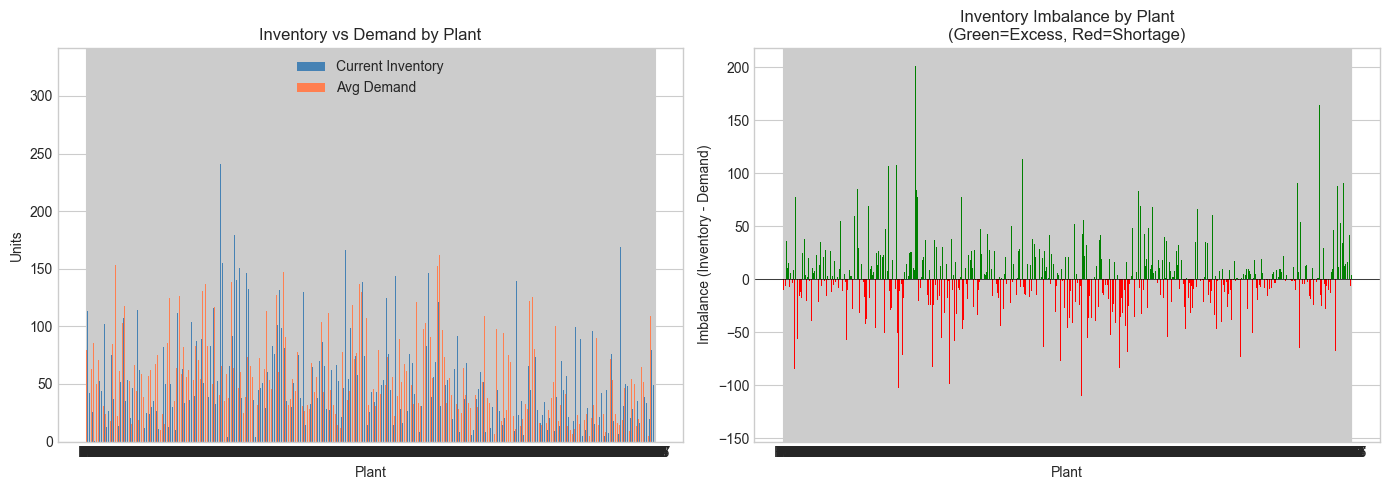

In [13]:
# Visualize imbalances
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Inventory vs Demand
x = np.arange(len(plant_summary))
width = 0.35

axes[0].bar(x - width/2, plant_summary['current_inventory'], width, label='Current Inventory', color='steelblue')
axes[0].bar(x + width/2, plant_summary['avg_demand'], width, label='Avg Demand', color='coral')
axes[0].set_xlabel('Plant')
axes[0].set_ylabel('Units')
axes[0].set_title('Inventory vs Demand by Plant')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f'P{p}' for p in plant_summary['plant_id']])
axes[0].legend()

# Plot 2: Inventory Imbalance
colors = ['green' if v > 0 else 'red' for v in plant_summary['inventory_imbalance']]
axes[1].bar(x, plant_summary['inventory_imbalance'], color=colors)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Plant')
axes[1].set_ylabel('Imbalance (Inventory - Demand)')
axes[1].set_title('Inventory Imbalance by Plant\n(Green=Excess, Red=Shortage)')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'P{p}' for p in plant_summary['plant_id']])

plt.tight_layout()
plt.show()


## 10. Save Processed Data


In [15]:
# Save processed datasets for next steps
plant_daily.to_csv('data/processed_plant_daily.csv', index=False)
plant_summary.to_csv('data/processed_plant_summary.csv', index=False)
cost_df.to_csv('data/transport_cost_matrix.csv')

print("Saved:")
print("  - data/processed_plant_daily.csv")
print("  - data/processed_plant_summary.csv")
print("  - data/transport_cost_matrix.csv")


Saved:
  - data/processed_plant_daily.csv
  - data/processed_plant_summary.csv
  - data/transport_cost_matrix.csv


---

## Summary

**Data processed:**
- Demand data aggregated to plant-day level
- Transport parameters extracted from logistics data
- Synthetic transport cost matrix created
- Inventory imbalances visualized

**Next Steps:**
1. `02_demand_forecasting.ipynb` - Build demand prediction model
2. `03_optimization_model.ipynb` - Formulate and solve allocation problem
